# Trabajo práctico 1 - Marcelo Chichiri


**Human activity recognition**

https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/intro_ia/tree/cohorte-6/clase_2/jupyterbooks/data

**MNIST**

    from sklearn.datasets import fetch_openml
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)


Deben maximizarse la cantidad de operaciones vectorizadas en las implementaciones.


## Ejercicio 1 - Implementar clase PCA con numpy
**Dataset** Human activity recognition

Tomar las primeras 63 componentes principales y calcular la varianza contemplada. Realizar las operaciones internas con numpy.linalg. 

In [1]:
class miPCA:
    def __init__(self, data):
        self.data = data
        self.filas, self.columnas = np.shape(data)
    
    def covarianza(self, data):
        # Calcula matriz de covarianza
        return np.cov(self.data , rowvar = False)
        
    def autovalores(self, mat_covarianza):
        # Calcula autovalores y autovectores
        autovals , autovecs = np.linalg.eigh(mat_covarianza)
        return (autovals , autovecs)
    
    def ordenar_autoval(self, autovalores, autovectores):
        # Ordenar autovalores y autovectores en forma descendente
        indices = np.argsort(autovalores)[::-1]
        autovals_ordenados = autovalores[indices]
        autovecs_ordenados = autovectores[:,indices]
        return (autovals_ordenados, autovecs_ordenados)
        
    def fit(self, nro_comp = -1):
    
        if nro_comp < 1:
            self.nro_comp = self.columnas

        # Calcula matriz de covarianza
        cov_mat = self.covarianza(self.data)
     
        # Calcula autovalores y autovectores
        autovals , autovecs = self.autovalores(cov_mat)
        
        # Ordenar autovalores y autovectores en forma descendente
        autovals_ordenados, autovecs_ordenados = self.ordenar_autoval(autovals , autovecs)
        
        # Truca los valores al numero de datos indicados
        autovecs_trucados = autovecs_ordenados[:,0:nro_comp]
     
        # Proyecta los valores sobre la matriz de covarianza
        data_reducida = np.dot(self.data, autovecs_trucados)
        
        return data_reducida
    
    def var_contem(self, componentes=-1):
        if componentes < 1:
            componentes = self.columnas
        
        # Calcula matriz de covarianza
        cov_mat = self.covarianza(self.data)
        
        # Calcula autovalores y autovectores
        autovals , autovecs = self.autovalores(cov_mat)
        
        # Ordenar autovalores y autovectores en forma descendente
        autovals_ordenados, autovecs_ordenados = self.ordenar_autoval(autovals , autovecs)
        
        autovals_total = np.sum(autovals)        
        var_exp = [(i/autovals_total) for i in autovals]
        cum_sum_exp = np.cumsum(var_exp)
        
        # Truca los valores al numero de datos indicados
        autovals_trucados = autovals_ordenados[:componentes+1]
        
        # Calcula varianza contemplada
        #autovals_total = np.sum(autovals_trucados)
        autovals_total = np.sum(autovals_ordenados)
        var_relativa = [(i/autovals_total) for i in autovals_trucados]
        var_contemplada = np.cumsum(var_relativa)
        
        return var_contemplada

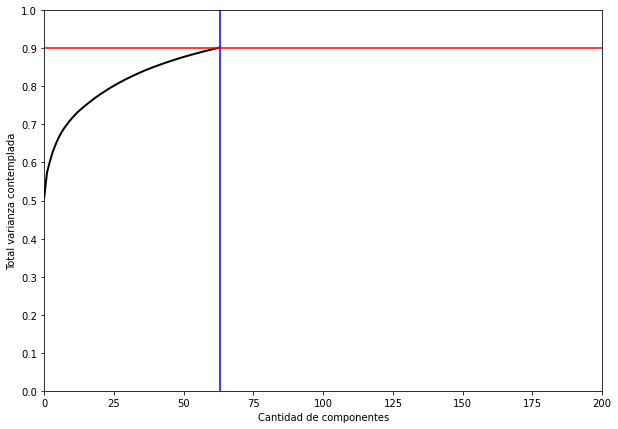

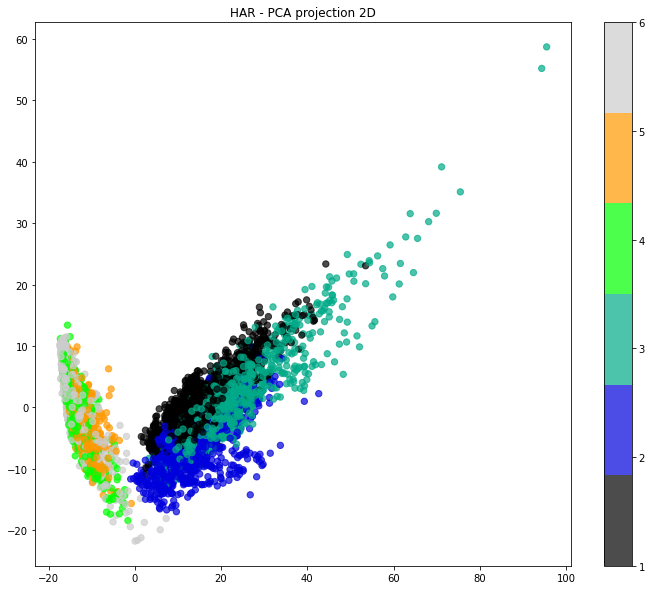

In [2]:
import os
import numpy as np
#import pandas as pd
from sklearn.preprocessing import StandardScaler

PATH_DATASET = "C:/EspecializaciónEnInteligenciaArtificial/INTRODUCCION A LA INTELIGENCIA ARTIFICIAL/TPs/UCI HAR Dataset/train"
X_train = np.loadtxt(os.path.join(PATH_DATASET, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_DATASET, "y_train.txt")).astype(int)

# Estandarizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# clase miPCA
pca = miPCA(X_scaled)
matriz_reducida = pca.fit()

var_contemplada = pca.var_contem(componentes=63)
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10,7))
plt.plot(var_contemplada, color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 200)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(63, c='b')
plt.axhline(0.9, c='r')
plt.show();


plt.figure(figsize=(12,10))
plt.scatter(matriz_reducida[:, 0], matriz_reducida[:, 1], c=y_train, alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False #Evita un warning
plt.colorbar()
plt.title('HAR - PCA projection 2D');

## Ejercicio 2 - Implementar clase KMeans con numpy
**Dataset** Human activity recognition

Implementar kmeans con numpy. Agrupar el dataset transformado (ejercicio de PCA) y agrupar en clusters de k=2 y 6. Graficar los casos de k=2 y k=6 con las primeras dos componentes principales.

1. Inicializo los k centroides de forma aleatoria
2. Calculo la suma de desviaciones al cuadrado.
3. Asignar un centroide a cada una de las observaciones.
4. Calcular el error total y compararla con la suma en la anterior iteración.
5. Recalcular centroides y repetir el proceso hasta que se cumplan los ciclos indicados o que la variacion del error cuadratico medio sea menor a uno indicado

In [3]:
class miKMeans:
    def __init__(self, data):
        self.data = data
        
        n_dims = data.shape[1]
        centroid_min = data.min()
        centroid_max = data.max()
        
    def calcula_distancia(self, x, centroides):
        # Calcula la distancia entre x y cada uno de los centroides
        distancia = ((x - centroides) ** 2).sum(axis = 1)
        return distancia

    def centroide_cercano(self, x, centroides):
        # Recorre cada centroide y verifica la distancia del dato x con cada uno
        distancia = self.calcula_distancia(x, centroides)
        
        # devuelve el indice de la menor distancia 
        indice_centroide_cercano =  np.argmin(distancia)
        return indice_centroide_cercano
    
    def calcula_ecm(self, data, centroides, centroide_asignado):
        # Calcula el error cuadrado medio 
        sum_errores = self.calcula_distancia(self.data, centroides[centroide_asignado]).sum() / len(self.data)
        return sum_errores    

    def fit(self, k=2, max_ciclos=10, min_dec=0):
        # Parametros:
                # k : cantidad de clusters
                # max_ciclos : maxima cantidad de ciclos de ajustes
                # min_dec : minimo decremento del error cuadrado medio. POr debajo de ese valor se deja de ciclar
                
        # Inicializa una lista con valores aleatorios para guardar los centroides. 
        # Dimension: cantidad de datos (filas) del dataset x cantidad de clusters.          
        centroides = []
        centroides = self.data[random.sample(range(self.data.shape[0]), k)]
        
        # Inicializa una lista con ceros para guardar los centroides asignados a cada dato del dataset
        # Esta lista esta emparejada con cada fila del dataset y se usa como una extencion de ese
        # Dimension : cantidad de datos (filas) del dataset
        centroide_asignado = np.zeros(len(self.data), dtype = np.int32)
        
        # Inicializa una lista con la dimension que debe tener un centroide. 
        # Dimension : cantidad de atributos (columnas) del dataset
        dim_centroide = self.data.shape[1]

        #print('Dimensiones del centroide ', dim_centroide)

        # Inicializa una lista para guardar los errores cuadrados medios de cada ciclo
        # Dimension : variables, depende de la cantidad de iteraciones finales
        lista_ecm = []

        # Loop para hacer tanta cantidad de ajustes de los centroides como se indica en el parametro ciclos
        for n in range(max_ciclos):
    
            # Loop para recorrer cada uno de los datos y asignar el centroide mas cercano
            # El centroide mas cercano se guarda en la lista centroide_asignado cuyo indice esta emprejado con 
            # el indice del dataset.
            for i in range(len(self.data)):
               
                # en x va el dato de la fila del dataset para asignarle un centroide
                x = self.data[i]
                
                # Se transpone x para que tenga una fila y n columnas
                x = x[None, :]  
                
                # Busca el centroide mas cercano al dato del dataset pasado en x
                # y lo asigna a la lista centroide_asignado. Esta lista esta emparejada con cada fila del dataset, es
                # decir que es como una extension del dataset
                centroide_asignado[i] = self.centroide_cercano(x, centroides)
    
            # Una vez que cada dato del dataset tiene el centroide mas cercano asignado, este loop recorre cada centroide
            # y lo recalcula para centrarlo en los datos que lo tienen como centroide asignado.
            for c in range(len(centroides)):
                # Toma todos los datos del dataset que esten asignados al centroide indicado en c 

                cluster = self.data[centroide_asignado == c]
                #print(cluster_data)
        
                # Con todos los datos que estan asignados al centroide dado calcula la media para ajustar el valor del 
                # centroide 
                centroides[c] = cluster.mean(axis = 0)
        
        
            # Calcula el error cuadrado medio para este ciclo
            ecm = self.calcula_ecm(self.data, centroides, centroide_asignado)
            
            if (n > 0):
                if (lista_ecm[len(lista_ecm)-1] - ecm < min_dec):
                    lista_ecm.append(ecm)
                    break  # Si el ecm disminuyo menos de un parametro dado, el proceso termina
            lista_ecm.append(ecm)
        
        return (centroides, centroide_asignado, lista_ecm)

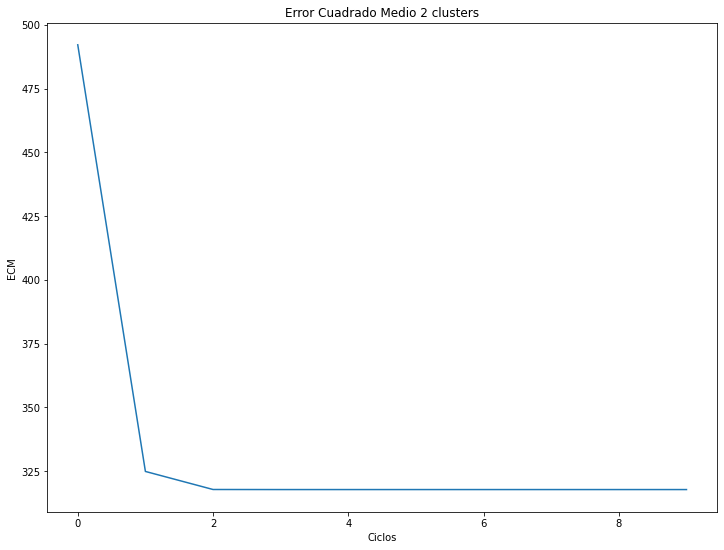

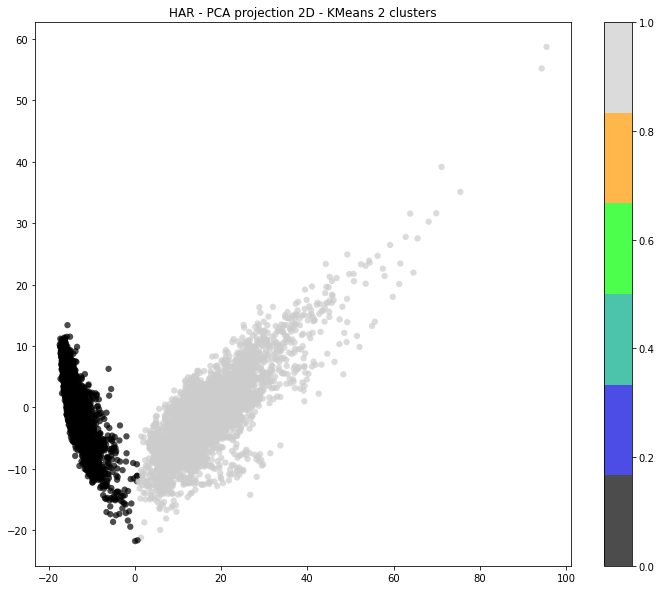

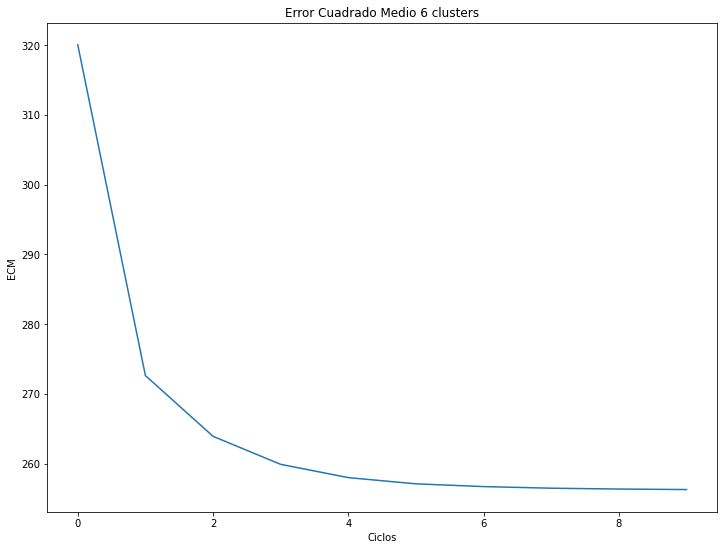

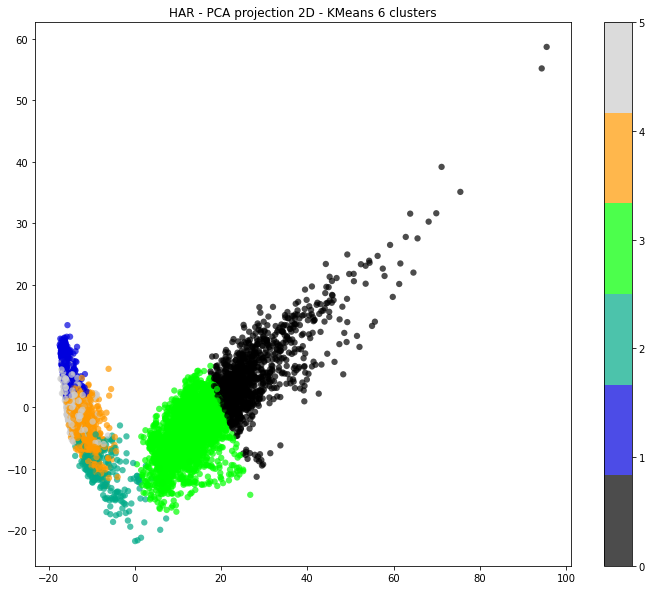

In [4]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 


PATH_DATASET = "C:/EspecializaciónEnInteligenciaArtificial/INTRODUCCION A LA INTELIGENCIA ARTIFICIAL/TPs/UCI HAR Dataset/train"
X_train = np.loadtxt(os.path.join(PATH_DATASET, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_DATASET, "y_train.txt")).astype(int)

# Estandarizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# clase miPCA
pca = miPCA(X_scaled)
matriz_reducida = pca.fit()

# KMeans con 2 clusters
x = miKMeans(matriz_reducida)
centroides, clusters, ecm = x.fit(k=2, max_ciclos=10)

plt.figure()
plt.xlabel("Ciclos")
plt.ylabel("ECM")
plt.plot(range(len(ecm)), ecm)
plt.title('Error Cuadrado Medio 2 clusters');
plt.show()

plt.figure(figsize=(12,10))
plt.scatter(matriz_reducida[:, 0], matriz_reducida[:, 1], c=clusters, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('HAR - PCA projection 2D - KMeans 2 clusters');

# KMeans con 6 clusters
centroides, clusters, ecm = x.fit(k=6, max_ciclos=10)

plt.figure()
plt.xlabel("Ciclos")
plt.ylabel("ECM")
plt.plot(range(len(ecm)), ecm)
plt.title('Error Cuadrado Medio 6 clusters');
plt.show()

plt.figure(figsize=(12,10))
plt.scatter(matriz_reducida[:, 0], matriz_reducida[:, 1], c=clusters, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('HAR - PCA projection 2D - KMeans 6 clusters');

## Ejercicio 3 - Comparar los ejercicios anteriores con lo visto en las clases

El resultado de los ejercicios 1 y 2 dieron resultamos muy similares a los vistos en clases, tanto en PCA reduciendo la cantidad de datos y mostrando la varianza contemplada, como con KMeans agrupando los datos en 2 y 6 clusters. 

## Ejercicio 4 - PCA + KMeans

**Dataset**: MNIST

Con las implementaciones de sklearn, tomar las componentes principales que capturen el 90% de la varianza y aplicar kmeans para agrupar los dígitos en 10 clusters. Analizar los resultados. 

In [6]:
# Se cargan las librerias 
import os
import numpy as np
import pandas as pd
import seaborn as sns
#from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

RANDOM_STATE = 17

In [7]:
# Se carga el dataset
X_train, y_train = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

(70000,)
(70000, 784)
['5' '0' '4' '1' '9' '2' '1' '3' '1' '4']


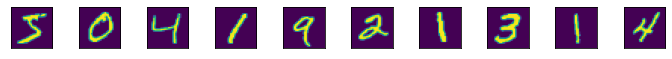

In [8]:
# Muestra los primeros digitos
import matplotlib.pyplot as plt
print(np.shape(y_train))
print(np.shape(X_train))
print(y_train[0:10])
nro_imagenes = 10

for nro_digit in range(0,nro_imagenes): 
            plt.subplot(10,10,nro_digit+1) #crea subplot
            numero = X_train[nro_digit].reshape(28,28)  #convierte la imagen a 28x28
            plt.imshow(numero) #muestra el dato
            plt.xticks([]) #remueve el numero de etiquetas en el eje x
            plt.yticks([]) #remueve el numero de etiquetas en el eje y

In [9]:
# Muestra la estructura de los datos
print("Estructura features del dataset: {}".format(X_train.shape))
print("Estructura de las etiquetas: {}".format(y_train.shape))

Estructura features del dataset: (70000, 784)
Estructura de las etiquetas: (70000,)


In [10]:
# Muestra un resumen de los features
df = pd.DataFrame(data=X_train)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [11]:
# Muestra las clases
clases = np.unique(y_train)
n_clases = clases.size
print('clases: ', clases)
print('numero de clases: ', n_clases)

clases:  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
numero de clases:  10


Cantidad de componentes necesarios:  238


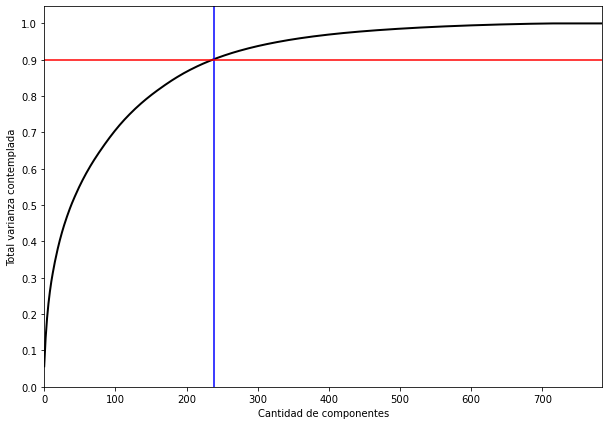

In [12]:
# Estandarizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)

X_pca = pca.transform(X_scaled)
# Cantidad de componentes necesarios
print('Cantidad de componentes necesarios: ', X_pca.shape[1])

pca_2 = PCA(n_components=X_scaled.shape[1], random_state=RANDOM_STATE).fit(X_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, X_train.shape[1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(X_pca.shape[1], c='b')
plt.axhline(0.9, c='r')
plt.show();


Tamaño comprimido:  (70000, 238)
Tamaño recuperado:  (70000, 784)


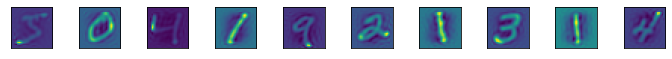

In [13]:
# Se prueba la recuepracion de los datos
print('Tamaño comprimido: ', np.shape(X_pca))
nro_imagenes = 10

recuperacion = pca.inverse_transform(X_pca)
print('Tamaño recuperado: ', np.shape(recuperacion))

for nro_digit in range(0, nro_imagenes): 
            plt.subplot(10,10,nro_digit+1) #crea subplot
            numero = recuperacion[nro_digit].reshape(28, 28)  #convierte la imagen a 28x28
            plt.imshow(numero) #muestra el dato
            plt.xticks([]) #remueve el numero de etiquetas en el eje x
            plt.yticks([]) #remueve el numero de etiquetas en el eje y

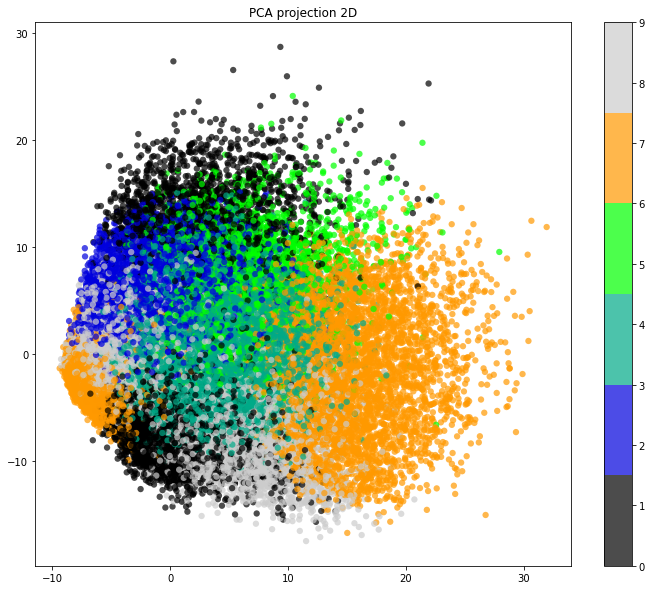

In [15]:
#Calculo de centroides para cada uno de los clusters
n_clases = 10
kmeans = KMeans(n_clusters=n_clases, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

# Graficamos los primeros dos componentes
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('PCA projection 2D');

De la aplicación de PCA se obtiene que con 238 componentes (en este caso pixeles) principales, de los 784, se capturan el 90% de la varianza. Se ve que a partir de esos 238 componentes se puede recuperar la informacion original.

Aplicando kmeans para agrupar los dígitos en 10 clusters, no se ve una clara distincion entre los distintos clusters, aunque hay que conciderar tambien que en el grafico solo se muestran los dos primeros componentes de los datos.
